In [27]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.inference import Inference
from gpytorch.random_variables import GaussianRandomVariable

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
train_x = Variable(torch.linspace(0, 1, 1000))
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [29]:
class KissGPModel(gpytorch.GPModel):
    def __init__(self):
        super(KissGPModel, self).__init__(GaussianLikelihood())
        self.mean_module = ConstantMean()
        covar_module = RBFKernel()
        self.grid_covar_module = GridInterpolationKernel(covar_module, 50)
        self.register_parameter('log_noise', nn.Parameter(torch.Tensor([-2])), bounds=(-5, 5)),
        self.register_parameter('log_lengthscale', nn.Parameter(torch.Tensor([0])), bounds=(-3, 5)),
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-3, 5))

    def forward(self, x):
        mean_x = self.mean_module(x, constant=Variable(torch.Tensor([0])))
        covar_x = self.grid_covar_module(x, log_lengthscale=self.log_lengthscale)
        covar_x = covar_x.mul(self.log_outputscale.exp())

        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred, self.log_noise
    
prior_model = KissGPModel()

In [30]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 51))
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        if plot_train_data:
            ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

<IPython.core.display.Javascript object>


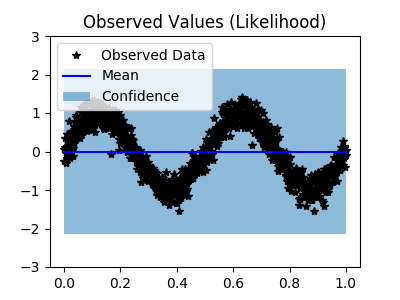

In [31]:
f = plot_model_and_predictions(prior_model, plot_train_data=True)

In [32]:
infer = Inference(prior_model)
posterior_model = infer.run(train_x, train_y, max_inference_steps=1)

# Optimize the model
posterior_model.train()
optimizer = optim.Adam(posterior_model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(30):
    optimizer.zero_grad()
    output = posterior_model(train_x)
    loss = -posterior_model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    optimizer.step()

_ = posterior_model.eval()

<IPython.core.display.Javascript object>


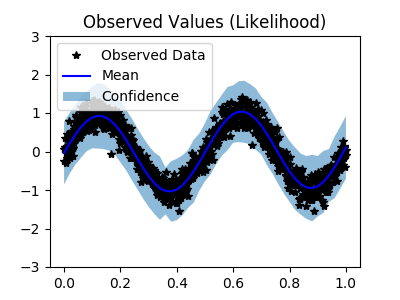

In [33]:
f = plot_model_and_predictions(posterior_model, plot_train_data=True)